In [20]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


In [21]:
# Constants
NUM_ARMS = 10       # Number of arms in the bandit
NUM_RUNS = 2000     # Number of independent runs
NUM_STEPS = 1000    # Number of time steps per run


In [22]:
class Bandit:
    """
    Simulates a k-armed bandit problem.
    """
    def __init__(self, k=NUM_ARMS):
        self.k = k
        # Initialize true action values with normal distribution N(0,1)
        self.q_true = np.random.normal(0, 1, k)
        
    def step(self, action):
        """
        Simulates pulling an arm and returns the reward.
        
        Args:
            action (int): The action selected.
        
        Returns:
            float: Reward from the selected action.
        """
        # Reward is drawn from a normal distribution centered at the true action value
        reward = np.random.normal(self.q_true[action], 1)
        return reward
    

In [23]:
class Agent:
    """
    Base class for agents interacting with the bandit.
    """
    def __init__(self, k):
        self.k = k
        # Initialize estimated action values and action counts
        self.q_estimates = np.zeros(k)
        self.action_counts = np.zeros(k)
        
    def act(self):
        """
        Selects an action.
        """
        raise NotImplementedError("This method should be overridden by subclasses.")
        
    def learn(self, action, reward):
        """
        Updates the estimated values based on the action taken and reward received.
        
        Args:
            action (int): The action taken.
            reward (float): The reward received.
        """
        self.action_counts[action] += 1
        # Incremental update of estimated action value
        self.q_estimates[action] += (reward - self.q_estimates[action]) / self.action_counts[action]


In [24]:
class EpsilonGreedyAgent(Agent):
    """
    Epsilon-Greedy Agent for the bandit problem.
    """
    def __init__(self, k, epsilon):
        super().__init__(k)
        self.epsilon = epsilon
        
    def act(self):
        """
        Selects an action using the epsilon-greedy strategy.
        
        Returns:
            int: The action selected.
        """
        if np.random.rand() < self.epsilon:
            # Exploration: randomly select an action
            return np.random.randint(self.k)
        else:
            # Exploitation: select the action with the highest estimated value
            return np.argmax(self.q_estimates)
        

In [25]:
class UCBAgent(Agent):
    """
    Upper Confidence Bound (UCB) Agent for the bandit problem.
    """
    def __init__(self, k, c):
        super().__init__(k)
        self.c = c
        self.total_steps = 0
        
    def act(self):
        """
        Selects an action using the UCB strategy.
        
        Returns:
            int: The action selected.
        """
        self.total_steps += 1
        # Calculate UCB values for each action
        ucb_values = np.zeros(self.k)
        for action in range(self.k):
            if self.action_counts[action] > 0:
                # Compute UCB value for actions that have been selected
                bonus = self.c * np.sqrt(np.log(self.total_steps) / self.action_counts[action])
                ucb_values[action] = self.q_estimates[action] + bonus
            else:
                # Assign infinity to actions not yet selected to ensure they are tried
                ucb_values[action] = float('inf')
        return np.argmax(ucb_values)
    

In [26]:
def single_run(agent_class, agent_params, steps):
    """
    Runs a single simulation of the bandit problem with a specified agent.
    
    Args:
        agent_class (class): The agent class to instantiate.
        agent_params (dict): Parameters for the agent.
        steps (int): Number of steps in the simulation.
    
    Returns:
        numpy.ndarray: Rewards over time.
    """
    rewards = np.zeros(steps)
    bandit = Bandit()
    agent = agent_class(bandit.k, **agent_params)
    for t in range(steps):
        action = agent.act()
        reward = bandit.step(action)
        agent.learn(action, reward)
        rewards[t] = reward
    return rewards

In [27]:
def simulate(runs, steps, agent_class, agent_params):
    """
    Simulates multiple runs of the bandit problem in parallel.
    
    Args:
        runs (int): Number of independent simulation runs.
        steps (int): Number of steps per run.
        agent_class (class): The agent class to use for simulation.
        agent_params (dict): Parameters for the agent.
    
    Returns:
        numpy.ndarray: Average rewards over time.
    """
    # Parallel execution of simulation runs
    results = Parallel(n_jobs=-1)(
        delayed(single_run)(agent_class, agent_params, steps) for _ in range(runs)
    )
    rewards = np.array(results)
    # Compute average rewards
    average_rewards = rewards.mean(axis=0)
    return average_rewards


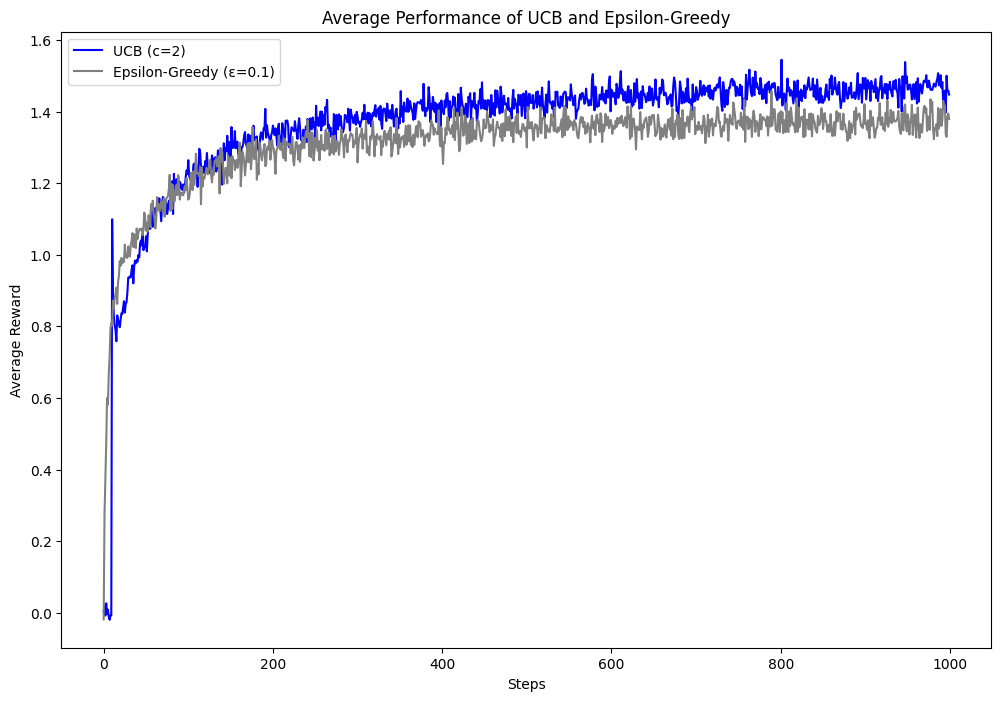

In [28]:
def main():
    """
    Main function to run simulations and plot the results.
    """
    # Simulate Epsilon-Greedy Agent with epsilon=0.1
    avg_rewards_eps = simulate(
        NUM_RUNS, NUM_STEPS, EpsilonGreedyAgent, {'epsilon': 0.1}
    )

    # Simulate UCB Agent with c=2
    avg_rewards_ucb = simulate(
        NUM_RUNS, NUM_STEPS, UCBAgent, {'c': 2}
    )

    # Plotting the results
    plt.figure(figsize=(12, 8))
    plt.plot(avg_rewards_ucb, label='UCB (c=2)', color='blue')
    plt.plot(avg_rewards_eps, label='Epsilon-Greedy (ε=0.1)', color='gray')
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.title('Average Performance of UCB and Epsilon-Greedy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
